In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix as cm,
    accuracy_score as acc,
    precision_score as prec,
    recall_score as rec,
    f1_score as f1
)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from ml_model_eval import pred_proba_plot, plot_cross_val_confusion_matrix, plot_learning_curve


In [7]:
matches = pd.read_csv("../matches_after_preprocessing.csv")

In [8]:
train = matches[matches["date"] < '2022-11-01']
test = matches[matches["date"] > '2022-11-01']
predictors = ["venue_code", "opp_code", "hour", "day_code", "gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"]
X_train = train[predictors]
y_train = train["target"]
X_test = test[predictors]
y_test = test["target"]
X_test.drop(["gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"], axis =1)

,venue_code,opp_code,hour,day_code
0,0,10,12,5
1,1,3,16,6
2,0,16,16,6
3,1,19,15,5
4,1,2,15,5
...,...,...,...,...
1717,0,17,14,6
1718,0,19,20,0
1719,1,9,15,5
1720,0,4,14,6


In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
confusion_matrix = cm(y_test, preds) 
accuracy_score = acc(y_test, preds)
precision_score = prec(y_test, preds)
recall_score = rec(y_test, preds)
f1_score = f1(y_test, preds)

In [10]:
print("confusion matrix", confusion_matrix)
print("accuracy score: ", accuracy_score)
print("precision score: ", precision_score)
print("recall score: ", recall_score)
print("f1 score: ", f1_score)

confusion matrix [[738 163]
 [350 228]]
accuracy score:  0.6531440162271805
precision score:  0.5831202046035806
recall score:  0.3944636678200692
f1 score:  0.47058823529411764


In [11]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1,2,5]
}
# Xây dựng mô hình Random Forest
rf = RandomForestClassifier()
#random forest gridsearch 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [12]:
best_params

{'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 200}

In [13]:
# Đánh giá mô hình
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
confusion_matrix = cm(y_test, preds)
accuracy = acc(y_test, preds)
precision = prec(y_test, preds)
recall = rec(y_test, preds)
f1 = f1(y_test, preds)

print("Confusion matrix:\n", confusion_matrix)
print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall score:", recall)
print("F1 score:", f1)

Confusion matrix:
 [[823  78]
 [431 147]]
Accuracy score: 0.6558485463150777
Precision score: 0.6533333333333333
Recall score: 0.25432525951557095
F1 score: 0.36612702366127026


In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=skf)
cv_accuracy = round(np.mean(cv_scores) * 100, 1)

print('Cross-Validation Accuracy Score: ', cv_accuracy, '%')


Cross-Validation Accuracy Score:  63.2 %


In [15]:
cv_scores

array([0.64550265, 0.64021164, 0.61375661, 0.63297872, 0.62765957])

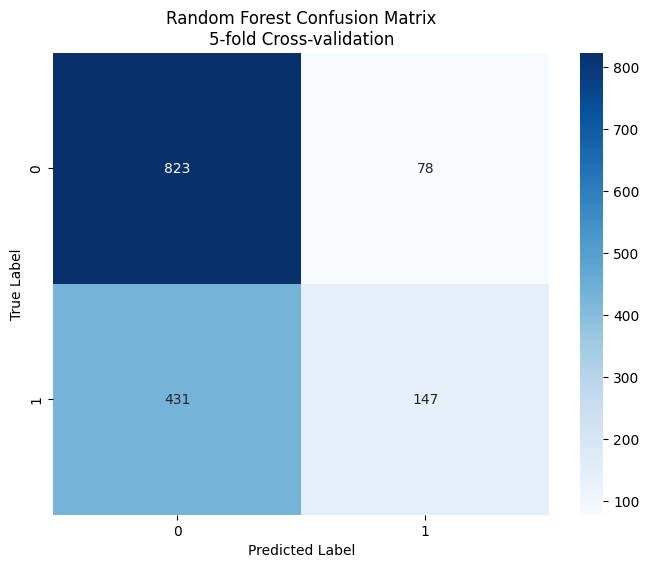

In [16]:
plot_cross_val_confusion_matrix(confusion_matrix, display_labels='', title='Random Forest Confusion Matrix', cv=5)
plt.show()

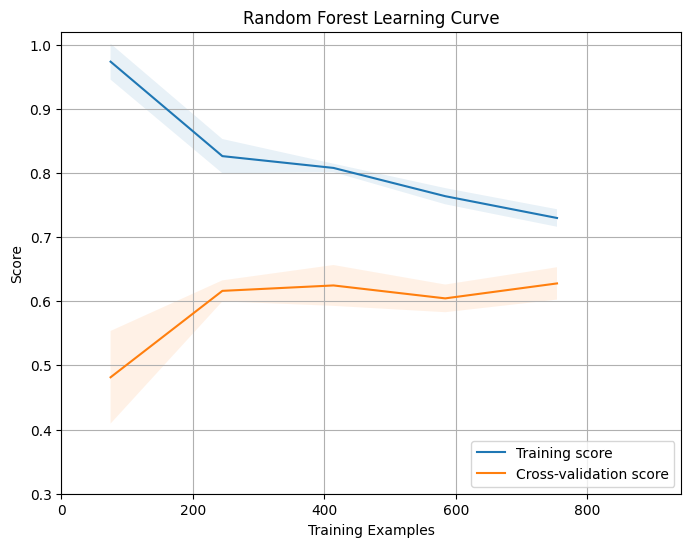

In [17]:
plot_learning_curve(rf, X_train, y_train, scoring='accuracy', training_set_size=5, cv=5, x_min=0, x_max=len(X_train), y_min=0.3, y_max=1.02, title='Random Forest Learning Curve', leg_loc=4)
plt.show()

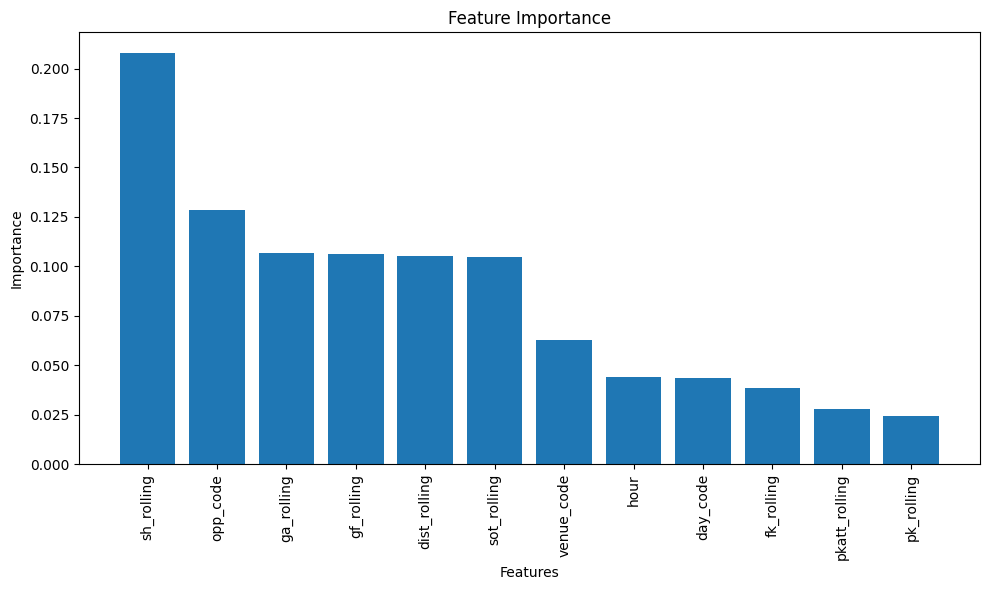

In [18]:
# Trích xuất mức độ quan trọng của các đặc trưng
importance = rf.feature_importances_

# Sắp xếp các đặc trưng theo mức độ quan trọng giảm dần
indices = np.argsort(importance)[::-1]

# Tạo danh sách tên các đặc trưng theo thứ tự quan trọng
feature_names = X_train.columns[indices]

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()